                       FASTTEXT FEATURE MODEL EVALUATION                        
Loading FastText features...
Loaded FastText features with dimension: 300
Total documents: 15000
Number of classes: 6
Training set: 12000 documents
Validation set: 3000 documents

Label mapping:
  0: economic
  1: environment
  2: health
  3: politic
  4: sport
  5: technology

Training models on FastText features...

Scaling features for MultinomialNB...
Features scaled to range [0,1] for compatibility with MultinomialNB

Training MultinomialNB...
MultinomialNB with alpha=0.01: validation accuracy = 0.8577
MultinomialNB with alpha=0.1: validation accuracy = 0.8580
MultinomialNB with alpha=0.5: validation accuracy = 0.8580
MultinomialNB with alpha=1.0: validation accuracy = 0.8587
Best alpha for MultinomialNB: 1.0 with accuracy: 0.8587
MultinomialNB - Train accuracy: 0.8542
MultinomialNB - Validation accuracy: 0.8587

Training Linear SVM...
SVM with C=0.1: validation accuracy = 0.9017
SVM with C=1.0: valid

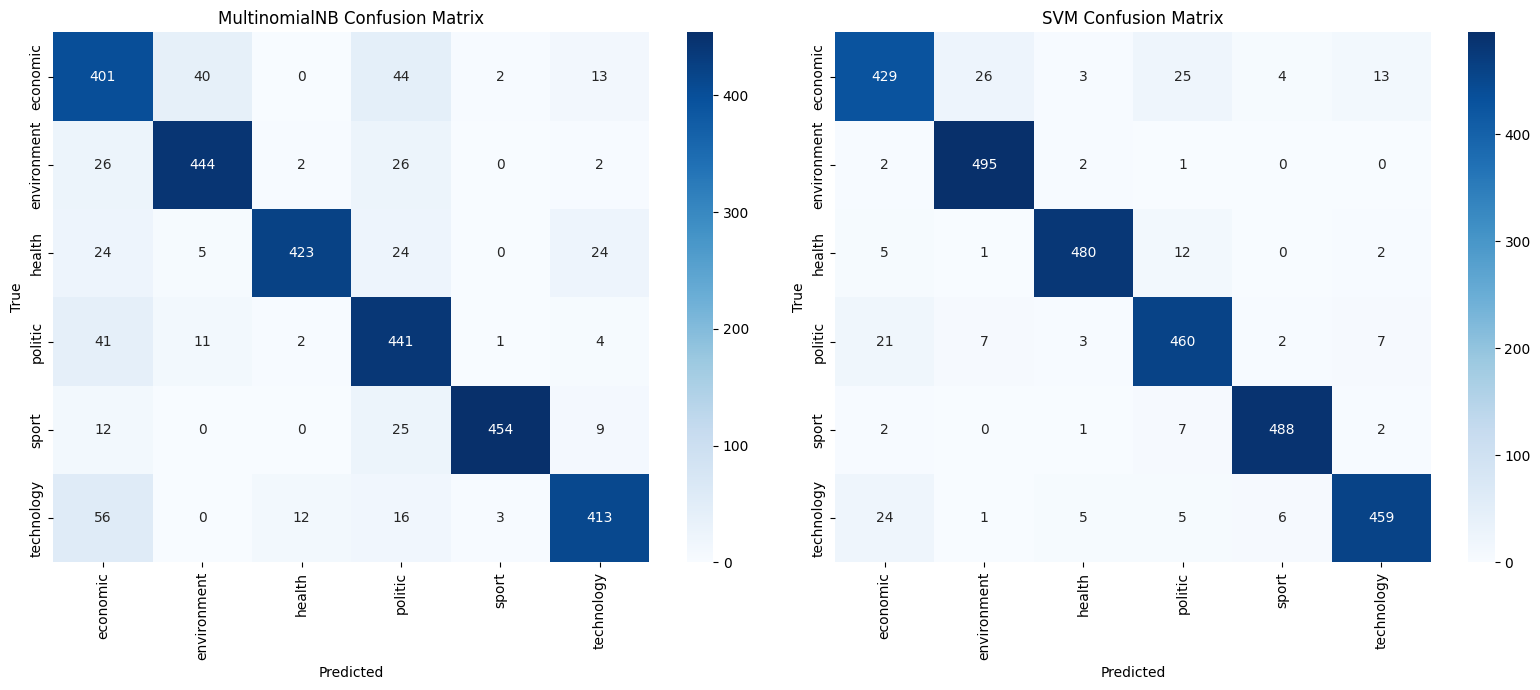

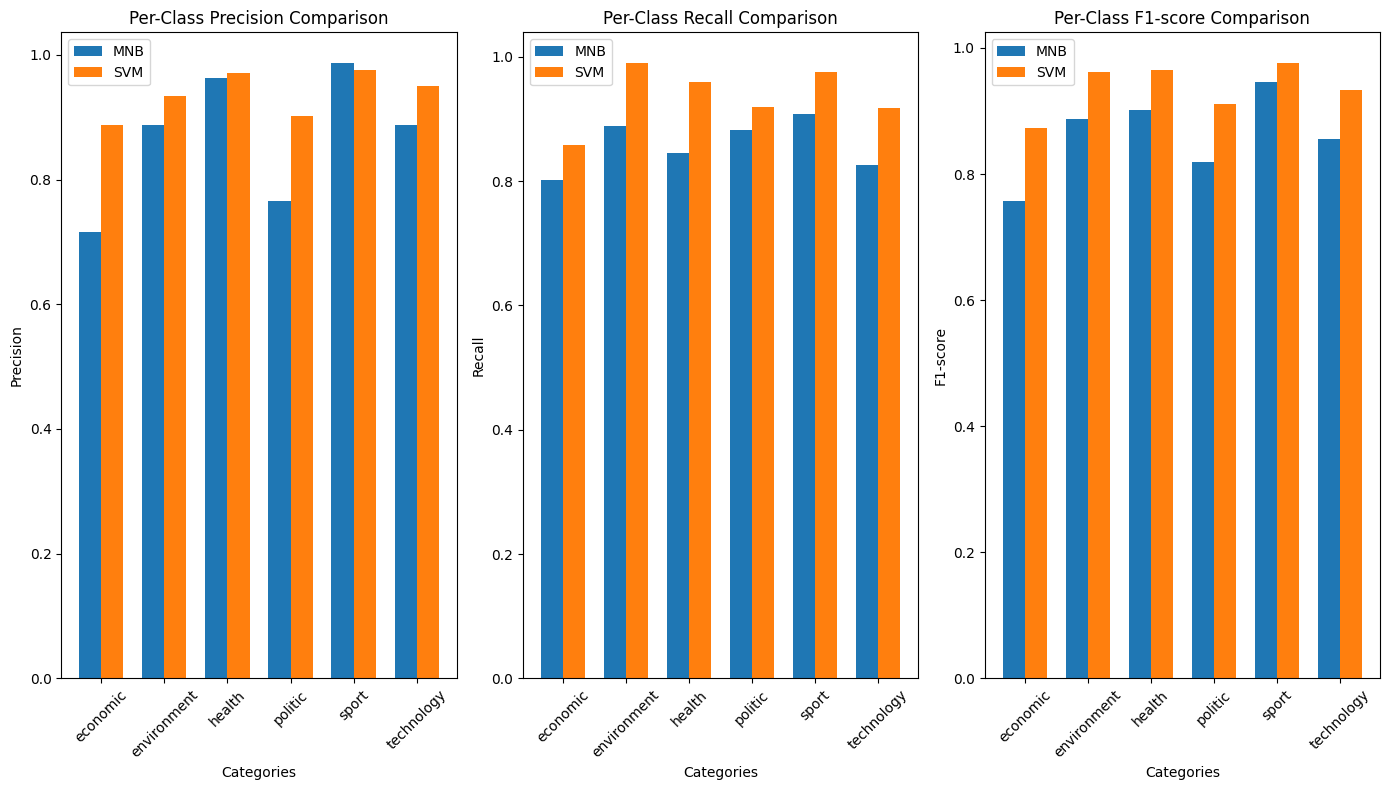


Best model: SVM with accuracy 0.9370

Per-class performance for SVM:
Category        Precision  Recall     F1-Score  
--------------------------------------------------
economic        0.8882     0.8580     0.8728
environment     0.9340     0.9900     0.9612
health          0.9717     0.9600     0.9658
politic         0.9020     0.9200     0.9109
sport           0.9760     0.9760     0.9760
technology      0.9503     0.9180     0.9339

Plots saved to FastText_Models directory.

FASTTEXT MODEL TRAINING AND EVALUATION COMPLETE


In [1]:
import os
import numpy as np
import pickle
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Define paths
BASE_DIR = '/Users/socheata/Documents/FYP-Khmer-Classification'
FASTTEXT_FEATURE_DIR = os.path.join(BASE_DIR, 'FastText_Features')
MODEL_DIR = os.path.join(BASE_DIR, 'Models/FastText_Models')
os.makedirs(MODEL_DIR, exist_ok=True)

def load_fasttext_data():
    """Load FastText features and labels from FastText_Features directory"""
    print("Loading FastText features...")

    X = np.load(os.path.join(FASTTEXT_FEATURE_DIR, 'embeddings.npy'))
    y = np.load(os.path.join(FASTTEXT_FEATURE_DIR, 'labels.npy'))
    doc_ids = np.load(os.path.join(FASTTEXT_FEATURE_DIR, 'doc_ids.npy'))

    # Encode labels if not already integers
    if y.dtype.type is np.str_ or y.dtype.type is np.object_:
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)
        # Save label encoder for future use
        with open(os.path.join(FASTTEXT_FEATURE_DIR, 'label_encoder.pkl'), 'wb') as f:
            pickle.dump(label_encoder, f)
    else:
        with open(os.path.join(FASTTEXT_FEATURE_DIR, 'label_encoder.pkl'), 'rb') as f:
            label_encoder = pickle.load(f)

    print(f"Loaded FastText features with dimension: {X.shape[1]}")
    print(f"Total documents: {len(X)}")
    print(f"Number of classes: {len(label_encoder.classes_)}")

    # Split into train/validation (80/20 split)
    X_train, X_valid, y_train, y_valid, doc_ids_train, doc_ids_valid = train_test_split(
        X, y, doc_ids, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {len(X_train)} documents")
    print(f"Validation set: {len(X_valid)} documents")

    # Print label mapping
    print("\nLabel mapping:")
    for i, category in enumerate(label_encoder.classes_):
        print(f"  {i}: {category}")

    return X_train, X_valid, y_train, y_valid, label_encoder

def prepare_features_for_mnb(X_train, X_valid):
    """Scale FastText features for MultinomialNB (expects non-negative features)"""
    print("\nScaling features for MultinomialNB...")
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    print("Features scaled to range [0,1] for compatibility with MultinomialNB")
    return X_train_scaled, X_valid_scaled, scaler

def train_and_evaluate_models(X_train, X_valid, y_train, y_valid, label_encoder):
    """Train and evaluate models on FastText features"""
    print("\nTraining models on FastText features...")
    models = {}

    # Scale features for MultinomialNB
    X_train_scaled, X_valid_scaled, scaler = prepare_features_for_mnb(X_train, X_valid)

    # Train MultinomialNB
    print("\nTraining MultinomialNB...")
    best_alpha, best_accuracy = None, 0
    for alpha in [0.01, 0.1, 0.5, 1.0]:
        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(X_train_scaled, y_train)
        accuracy = accuracy_score(y_valid, mnb.predict(X_valid_scaled))
        print(f"MultinomialNB with alpha={alpha}: validation accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha

    print(f"Best alpha for MultinomialNB: {best_alpha} with accuracy: {best_accuracy:.4f}")

    # Train with the best alpha
    mnb = MultinomialNB(alpha=best_alpha)
    mnb.fit(X_train_scaled, y_train)
    y_train_pred_mnb = mnb.predict(X_train_scaled)
    y_valid_pred_mnb = mnb.predict(X_valid_scaled)
    mnb_train_accuracy = accuracy_score(y_train, y_train_pred_mnb)
    mnb_valid_accuracy = accuracy_score(y_valid, y_valid_pred_mnb)
    print(f"MultinomialNB - Train accuracy: {mnb_train_accuracy:.4f}")
    print(f"MultinomialNB - Validation accuracy: {mnb_valid_accuracy:.4f}")

    # Train SVM
    print("\nTraining Linear SVM...")
    best_c, best_accuracy = None, 0
    for c in [0.1, 1.0, 10.0]:
        svm = LinearSVC(C=c, dual=False, max_iter=10000, random_state=42)
        svm.fit(X_train, y_train)
        accuracy = accuracy_score(y_valid, svm.predict(X_valid))
        print(f"SVM with C={c}: validation accuracy = {accuracy:.4f}")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c

    print(f"Best C for SVM: {best_c} with accuracy: {best_accuracy:.4f}")

    # Train with the best C
    svm = LinearSVC(C=best_c, dual=False, max_iter=10000, random_state=42)
    svm.fit(X_train, y_train)
    y_train_pred_svm = svm.predict(X_train)
    y_valid_pred_svm = svm.predict(X_valid)
    svm_train_accuracy = accuracy_score(y_train, y_train_pred_svm)
    svm_valid_accuracy = accuracy_score(y_valid, y_valid_pred_svm)
    print(f"SVM - Train accuracy: {svm_train_accuracy:.4f}")
    print(f"SVM - Validation accuracy: {svm_valid_accuracy:.4f}")

    # Store model results
    models['mnb'] = {
        'model': mnb,
        'train_accuracy': mnb_train_accuracy,
        'valid_accuracy': mnb_valid_accuracy,
        'train_report': classification_report(y_train, y_train_pred_mnb, target_names=label_encoder.classes_, output_dict=True),
        'valid_report': classification_report(y_valid, y_valid_pred_mnb, target_names=label_encoder.classes_, output_dict=True),
        'confusion_matrix': confusion_matrix(y_valid, y_valid_pred_mnb),
        'overfitting_gap': mnb_train_accuracy - mnb_valid_accuracy,
        'scaler': scaler
    }

    models['svm'] = {
        'model': svm,
        'train_accuracy': svm_train_accuracy,
        'valid_accuracy': svm_valid_accuracy,
        'train_report': classification_report(y_train, y_train_pred_svm, target_names=label_encoder.classes_, output_dict=True),
        'valid_report': classification_report(y_valid, y_valid_pred_svm, target_names=label_encoder.classes_, output_dict=True),
        'confusion_matrix': confusion_matrix(y_valid, y_valid_pred_svm),
        'overfitting_gap': svm_train_accuracy - svm_valid_accuracy
    }

    # Save the models
    with open(os.path.join(MODEL_DIR, 'fasttext_mnb_model.pkl'), 'wb') as f:
        pickle.dump(models['mnb'], f)
    with open(os.path.join(MODEL_DIR, 'fasttext_svm_model.pkl'), 'wb') as f:
        pickle.dump(models['svm'], f)
    print(f"\nModels saved to {MODEL_DIR}")

    return models

def compare_and_visualize_models(models, label_encoder):
    """Compare and visualize model performance"""
    print("\n" + "="*70)
    print("FASTTEXT MODEL COMPARISON")
    print("="*70)

    # Compare accuracy
    print("\nAccuracy Comparison:")
    print(f"MultinomialNB: {models['mnb']['valid_accuracy']:.4f}")
    print(f"SVM: {models['svm']['valid_accuracy']:.4f}")

    # Compare metrics
    print("\nWeighted Average Metrics Comparison:")
    mnb_weighted = models['mnb']['valid_report']['weighted avg']
    svm_weighted = models['svm']['valid_report']['weighted avg']
    metrics = ['precision', 'recall', 'f1-score']
    print(f"{'Metric':<15} {'MNB':<10} {'SVM':<10}")
    print("-"*35)
    for metric in metrics:
        print(f"{metric:<15} {mnb_weighted[metric]:.4f}    {svm_weighted[metric]:.4f}")

    # Plot confusion matrices
    class_names = label_encoder.classes_
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    sns.heatmap(models['mnb']['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('MultinomialNB Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.subplot(1, 2, 2)
    sns.heatmap(models['svm']['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'fasttext_model_confusion_matrices.png'))
    plt.show()

    # Plot per-class metrics
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        mnb_scores = [models['mnb']['valid_report'][cls][metric] for cls in class_names]
        svm_scores = [models['svm']['valid_report'][cls][metric] for cls in class_names]
        x = np.arange(len(class_names))
        width = 0.35
        plt.bar(x - width/2, mnb_scores, width, label='MNB')
        plt.bar(x + width/2, svm_scores, width, label='SVM')
        plt.xlabel('Categories')
        plt.ylabel(metric.capitalize())
        plt.title(f'Per-Class {metric.capitalize()} Comparison')
        plt.xticks(x, class_names, rotation=45)
        plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_DIR, 'fasttext_model_metrics_comparison.png'))
    plt.show()

    # Identify best model
    best_model = 'mnb' if models['mnb']['valid_accuracy'] > models['svm']['valid_accuracy'] else 'svm'
    print(f"\nBest model: {best_model.upper()} with accuracy {models[best_model]['valid_accuracy']:.4f}")

    # Per-class performance for best model
    print(f"\nPer-class performance for {best_model.upper()}:")
    model_report = models[best_model]['valid_report']
    print(f"{'Category':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-"*50)
    for cls in class_names:
        cls_metrics = model_report[cls]
        print(f"{cls:<15} {cls_metrics['precision']:.4f}     {cls_metrics['recall']:.4f}     {cls_metrics['f1-score']:.4f}")

    print("\nPlots saved to FastText_Models directory.")

def main():
    print("=" * 80)
    print("FASTTEXT FEATURE MODEL EVALUATION".center(80))
    print("=" * 80)

    # Load FastText features
    X_train, X_valid, y_train, y_valid, label_encoder = load_fasttext_data()

    # Train and evaluate models
    models = train_and_evaluate_models(X_train, X_valid, y_train, y_valid, label_encoder)

    # Compare and visualize model performance
    compare_and_visualize_models(models, label_encoder)

    print("\nFASTTEXT MODEL TRAINING AND EVALUATION COMPLETE")
    print("=" * 80)

if __name__ == "__main__":
    main()